In [37]:
import pyxdf
import mne
from mne.decoding import CSP
from mne.preprocessing import EOGRegression
from mne.stats import permutation_cluster_1samp_test as pcluster_test
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import train_test_split

from mnetools import streams2mnedata, preprocessing

In [38]:
# -- |Data details| --
participant_id = 4
session = 3
# -- |Data Selection| --
initial_run = 1
n_run = 2

# -- |Parameters| --
tmin= -0.5
tmax= 3

# -- |Event dictionary| --
# Set up your event name
events_id = {'none': 0, 'singleBlink': 1, 'doubleBlink': 2}

In [39]:
# -- |Local parameters|--
epochs_list = [] 

for i in range(initial_run,initial_run+n_run):
    # -- |File import| --
    streams, header = pyxdf.load_xdf(f"Data/sub-P{participant_id:003d}/ses-B{session:003d}/eeg/sub-P{participant_id:003d}_ses-B{session:003d}_task-Default_run-{i:003d}_eeg.xdf") #Example Data from Lab Recoder

    raw_mne, events = streams2mnedata(streams)
    # -- |Common Average Reference| --
    mne_car = raw_mne.copy().set_eeg_reference('average', verbose=False)

    # -- |Bandpass filter| --
    mne_filtered = mne_car.filter(l_freq=2.0, h_freq=15.0, fir_design='firwin',picks ='all', verbose=False)
    
    # -- |Epoch Segmentation| --
    epochs = mne.Epochs(mne_filtered, events, tmin= tmin,  tmax= tmax, event_id = events_id, preload = True,verbose=False,picks = ['C3','Cz','C4','PO7','Pz','PO8','EOG'])

    epochs_list.append(epochs)

epochs_blink = mne.concatenate_epochs(epochs_list)
epochs_blink.set_montage(mne.channels.make_standard_montage('standard_1020'))

Not setting metadata
138 matching events found
Applying baseline correction (mode: mean)


Number of events,138
Events,doubleBlink: 45none: 48singleBlink: 45
Time range,-0.500 – 3.000 s
Baseline,-0.500 – 0.000 s


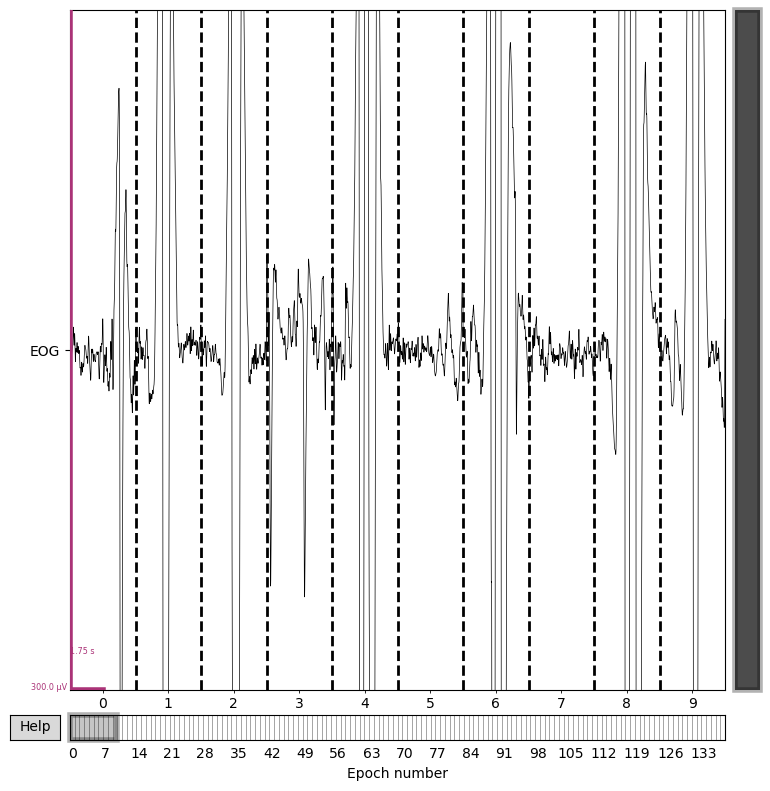

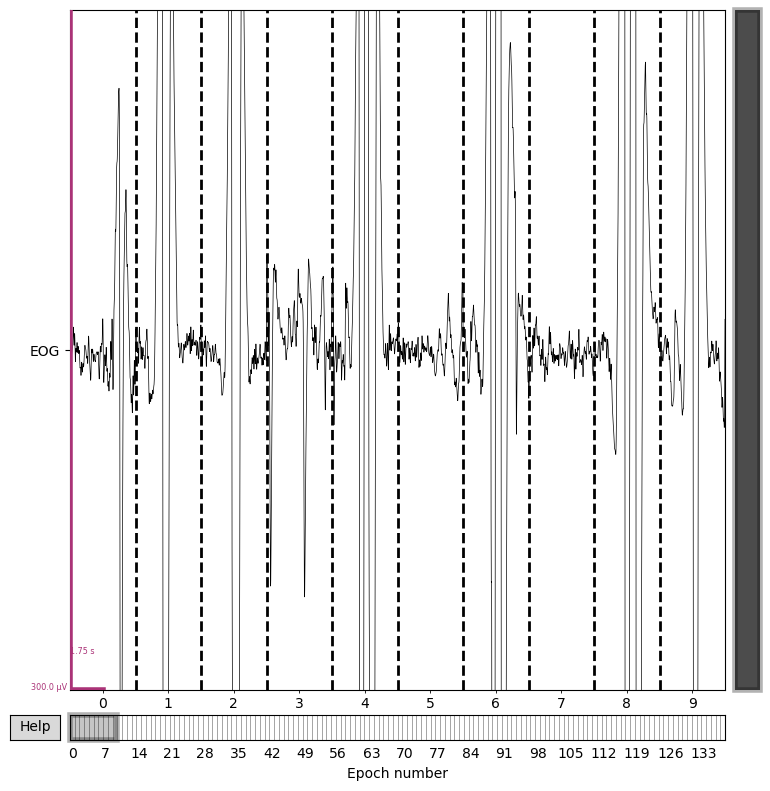

In [40]:
epochs_blink.plot(picks='EOG', n_epochs = 10)

In [41]:
epochs_blink.events = mne.merge_events(epochs_blink.events, [0, 1], 0, replace_events=True)
epochs_blink.events = mne.merge_events(epochs_blink.events, [2], 1, replace_events=True)
epochs_blink.event_id = {'none': 0, 'doubleBlink': 1}

X = epochs_blink.get_data(copy=False, picks = 'EOG')
Y = epochs_blink.events[:, -1]

In [42]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, stratify=Y)

In [43]:
X_train.shape

(110, 1, 876)

# **Threshold**

In [44]:
from sklearn.metrics import accuracy_score,classification_report

acc = []
A = []
for a in np.array(range(1,300))/100:
    threshold = np.mean(X_train) + a*np.std(X_train)
    Y_pred = []
    for i in range(X_train.shape[0]):
        if sum(X_train[i,0,:] > threshold) >= 2: Y_pred.append(1)
        else: Y_pred.append(0)
    Y_pred = np.array(Y_pred)

    A.append(a)
    acc.append(accuracy_score(Y_train, Y_pred))

threshold = np.mean(X_train) + A[np.argmax(acc)]*np.std(X_train)

Y_pred = []
for i in range(X_test.shape[0]):
    if sum(X_test[i,0,:] > threshold) >= 2: Y_pred.append(1)
    else: Y_pred.append(0)
Y_pred = np.array(Y_pred)

report = classification_report(Y_test, Y_pred, target_names = ['none','doubleBlink'])
print(report)

              precision    recall  f1-score   support

        none       1.00      0.79      0.88        19
 doubleBlink       0.69      1.00      0.82         9

    accuracy                           0.86        28
   macro avg       0.85      0.89      0.85        28
weighted avg       0.90      0.86      0.86        28



In [45]:
threshold

0.00038766120326594073

In [46]:
X_test[1,0,:].shape

(876,)

In [47]:
acc = []
A = []
for a in np.array(range(1,300))/100:
    threshold = np.mean(X) + a*np.std(X_train)
    Y_pred = []
    for i in range(X_train.shape[0]):
        if sum(X_train[i,:,0] > threshold) >= 2: Y_pred.append(1)
        else: Y_pred.append(0)
    Y_pred = np.array(Y_pred)

    A.append(a)
    acc.append(accuracy_score(Y_train, Y_pred))

threshold = np.mean(X_train) + A[np.argmax(acc)]*np.std(X_train)